## VisBikes
We import the bikes dataset and visualize some of the bikes in the dataset to get a feel for our task.

In [1]:
# Do the imports
import pickle
import hashlib
import os
import os.path
import re
import sys
import scipy
from scipy import ndimage
import cv2
import numpy as np
from numpy import *
import tensorflow as tf
from matplotlib import pyplot as plt
from tensorflow.python.platform import gfile
from tensorflow.python.util import compat

from IPython.core.display import Image 

TRAINING_IMAGES_DIR = os.getcwd() + '/training_images'
TEST_IMAGES_DIR = os.getcwd() + "/test_images/"
MAX_NUM_IMAGES_PER_CLASS = 2 ** 27 - 1  # ~134M

In [18]:
# Function to create a figure with given rows and columns
def createfigure_rc(rows, cols, fh, fw):
    #figwidth = 4;
    #figheight = 4;
    if(cols != 1):
        figwidth = fw/cols;
    if(cols!= 1):
        figheight = fh*rows
    fig = plt.figure(figsize=(figwidth, figheight), dpi= 80, facecolor='w', edgecolor='k') # Create new figure
    f0 = fig.add_subplot(111) # Main Figure subplot
    for r in range(rows):
        for c in range(cols):
            #print(f'{rows}, {cols}, {((r)*cols)+c+1}')
            fig.add_subplot(rows, cols, ((r)*cols)+c+1)
    f0.spines['top'].set_color('none')
    f0.spines['bottom'].set_color('none')
    f0.spines['left'].set_color('none')
    f0.spines['right'].set_color('none')
    f0.tick_params(labelcolor='w', top='off', bottom='off', left='off', right='off')
    # return fig, f1, f2 # Returns a tuple which is immutable
    return fig # Returns a list which is changable

In [3]:
# Function to create list of images in a directory (copied from inception example provided at )
#######################################################################################################################
def create_image_lists(image_dir, testing_percentage, validation_percentage):
    """
    Builds a list of training images from the file system.

    Analyzes the sub folders in the image directory, splits them into stable
    training, testing, and validation sets, and returns a data structure
    describing the lists of images for each label and their paths.

    Args:
        image_dir: String path to a folder containing subfolders of images.
        testing_percentage: Integer percentage of the images to reserve for tests.
        validation_percentage: Integer percentage of images reserved for validation.

    Returns:
        A dictionary containing an entry for each label subfolder, with images split
        into training, testing, and validation sets within each label.
    """
    if not gfile.Exists(image_dir):
        tf.logging.error("Image directory '" + image_dir + "' not found.")
        return None
    # end if

    result = {}
    sub_dirs = [x[0] for x in gfile.Walk(image_dir)]

    # The root directory comes first, so skip it.
    is_root_dir = True
    for sub_dir in sub_dirs:
        if is_root_dir:
            is_root_dir = False
            continue
        # end if
        extensions = ['jpg', 'jpeg']#, 'JPG', 'JPEG'] # Windows is not case sensitive, so you get 2X training data!
        file_list = []
        dir_name = os.path.basename(sub_dir)
        if dir_name == image_dir:
            continue
        # end if
        tf.logging.info("Looking for images in '" + dir_name + "'")
        for extension in extensions:
            file_glob = os.path.join(image_dir, dir_name, '*.' + extension)
            file_list.extend(gfile.Glob(file_glob))
        # end for
        if not file_list:
            tf.logging.warning('No files found')
            continue
        # end if
        if len(file_list) < 20:
            tf.logging.warning('WARNING: Folder has less than 20 images, which may cause issues.')
        elif len(file_list) > MAX_NUM_IMAGES_PER_CLASS:
            tf.logging.warning('WARNING: Folder {} has more than {} images. Some images will never be selected.'.format(dir_name, MAX_NUM_IMAGES_PER_CLASS))
        # end if
        label_name = re.sub(r'[^a-z0-9]+', ' ', dir_name.lower())
        training_images = []
        testing_images = []
        validation_images = []
        for file_name in file_list:
            base_name = os.path.basename(file_name)
            # We want to ignore anything after '_nohash_' in the file name when deciding which set to put an image in, the data set creator
            # has a way of grouping photos that are close variations of each other. For example this is used in the plant disease data set
            # to group multiple pictures of the same leaf.
            hash_name = re.sub(r'_nohash_.*$', '', file_name)
            # This looks a bit magical, but we need to decide whether this file should go into the training, testing, or validation sets,
            # and we want to keep existing files in the same set even if more files are subsequently added.  To do that, we need a stable
            # way of deciding based on just the file name itself, so we do a hash of that and then use that to generate a probability value
            # that we use to assign it.
            hash_name_hashed = hashlib.sha1(compat.as_bytes(hash_name)).hexdigest()
            percentage_hash = ((int(hash_name_hashed, 16) % (MAX_NUM_IMAGES_PER_CLASS + 1)) * (100.0 / MAX_NUM_IMAGES_PER_CLASS))
            if percentage_hash < validation_percentage:
                validation_images.append(base_name)
            elif percentage_hash < (testing_percentage + validation_percentage):
                testing_images.append(base_name)
            else:
                training_images.append(base_name)
            # end if
        result[label_name] = {'dir': dir_name, 'training': training_images, 'testing': testing_images, 'validation': validation_images,}
    return result
# end function

In [4]:
# load the images
image_lists = create_image_lists(TRAINING_IMAGES_DIR, 0, 10)

INFO:tensorflow:Looking for images in 'mountain_bikes'
INFO:tensorflow:Looking for images in 'road_bikes'


Lets try and look at some of the bike images in the training dataset

Text(0.5,1,'mountain_bike_33.jpg')

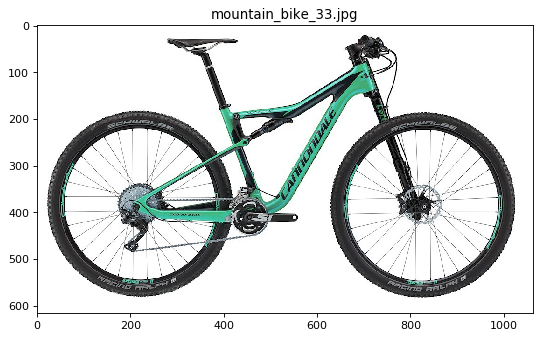

In [50]:
label = "mountain bikes"
num = np.random.randint(len(image_lists[label]["training"])); # Pick a random number
fig = plt.figure(figsize=(8, 8), dpi= 80, facecolor='w', edgecolor='k') # Create new figure
filename = image_lists[label]["training"][num]
path = TRAINING_IMAGES_DIR + "/" + image_lists[label]["dir"] + "/" + filename
im = cv2.imread(path)
plt.imshow(im)
plt.title(filename)

And road bikes

Text(0.5,1,'road_bike_80.jpg')

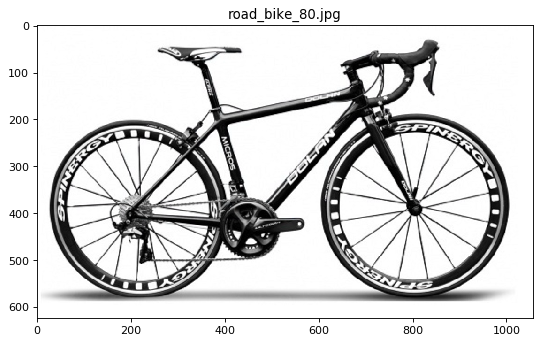

In [51]:
label = "road bikes"
num = np.random.randint(len(image_lists[label]["training"])); # Pick a random number
fig = plt.figure(figsize=(8, 8), dpi= 80, facecolor='w', edgecolor='k') # Create new figure
filename = image_lists[label]["training"][num]
path = TRAINING_IMAGES_DIR + "/" + image_lists[label]["dir"] + "/" + filename
im = cv2.imread(path)
plt.imshow(im)
plt.title(filename)

It looks like the tires, frames and locations of bike handles might look different between the two bikes.
Lets also look at the images at a resolution of 28X28, since that is what the MNIST dataset has.

Resolution of  C:\Users\s\Dropbox\BikeClassifier/training_images/road_bikes/road_bike_13.jpg  is  (655, 1047, 3)


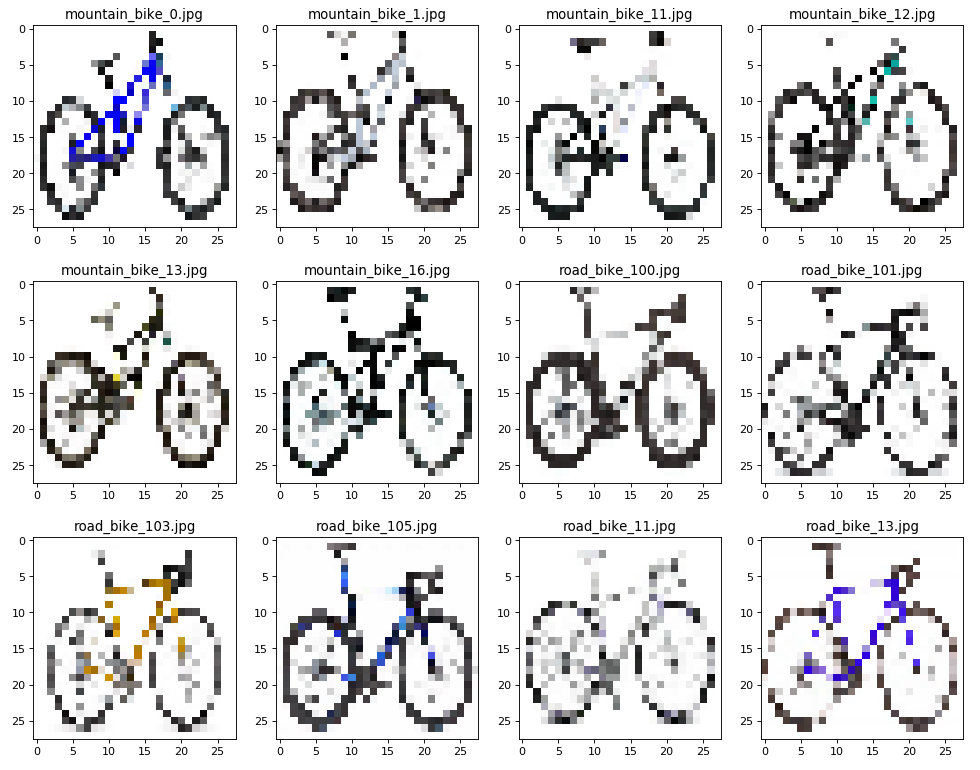

In [40]:
f = createfigure_rc(3,4, 4, 60)
figs = f.get_axes()
labelnum = 0;
for label in image_lists.keys():
    for x in range(6):
        plot = figs[(labelnum*6)+x+1]
        plt.sca(plot)
        filename = image_lists[label]["training"][x]
        path = TRAINING_IMAGES_DIR + "/" + image_lists[label]["dir"] + "/" + filename
        im = cv2.imread(path)
        res = cv2.resize(im,(28, 28), interpolation = cv2.INTER_CUBIC)
        plt.imshow(res)
        plt.title(filename)
    labelnum = labelnum + 1;
print("Resolution of ", path, " is ", im.shape)
plt.show()

It looks like a lot of bikes look very similar, and the dominant color in the images is black and white. So lets look at the bikes in grascale (making the images the same as the MNIST input images).

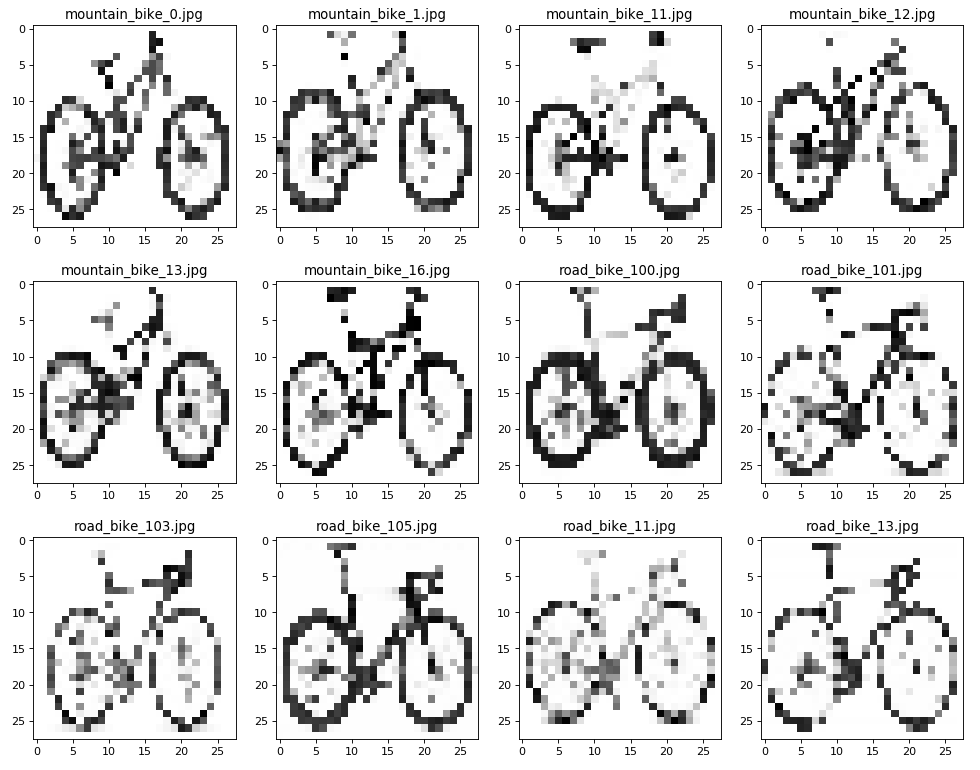

In [53]:
f = createfigure_rc(3,4, 4, 60)
figs = f.get_axes()
labelnum = 0;
for label in image_lists.keys():
    for x in range(6):
        plot = figs[(labelnum*6)+x+1]
        plt.sca(plot)
        filename = image_lists[label]["training"][x]
        path = TRAINING_IMAGES_DIR + "/" + image_lists[label]["dir"] + "/" + filename
        im = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
        res = cv2.resize(im,(28, 28), interpolation = cv2.INTER_CUBIC)
        plt.imshow(res, cmap = 'gray')
        plt.title(filename)
    labelnum = labelnum + 1;
plt.show()

Road bikes are pretty hard to differentiate from mountain bikes at this resolution for the human eye, but they have been reduced to "stick figures" or just their edges. Lets see if there is an "average" road bike or mountain bike and how dissimilar they are.

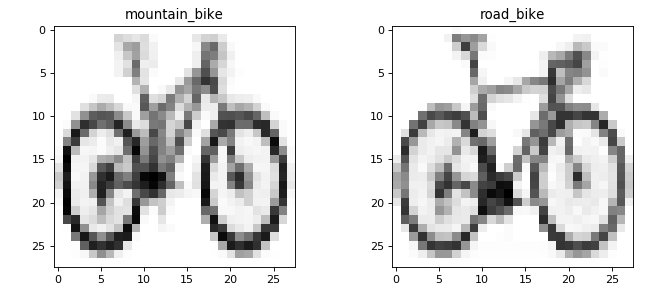

In [63]:
f = createfigure_rc(1,2, 4, 20)
figs = f.get_axes()
labelnum = 0;
average = {}
average["mountain bikes"] =  np.zeros((28,28))
average["road bikes"]= np.zeros((28,28))
for label in image_lists.keys():
    for x in range(50):
        filename = image_lists[label]["training"][x]
        path = TRAINING_IMAGES_DIR + "/" + image_lists[label]["dir"] + "/" + filename
        im = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
        res = cv2.resize(im,(28, 28), interpolation = cv2.INTER_CUBIC)
        average[label] = average[label] + res
        #plt.imshow(res, cmap = 'gray')
        #plt.title(filename)
    plot = figs[labelnum + 1]
    plt.sca(plot)
    average[label] = average[label] / 50
    plt.imshow(average[label], cmap = 'gray')
    plt.title(filename[0:len(filename)-len('_58.jpg')])
    labelnum = labelnum + 1;
plt.show()

The average images above show there is a slight difference in the size of the tires, and the location of the seats and handles for the two bikes. A traditional CV method of using the edges as features might be able to classify the two bike categories. For now, lets see how the example CNN for the MNIST dataset does.